In [1]:
GOOGLE_COLAB = True
if GOOGLE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')
    __dir__ = '/content/drive/My Drive/Colab Notebooks/nlp_ner_workshop'
else:
    from os.path import abspath
    __dir__ = abspath("../")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


## Reading the data

In [0]:
from zipfile import ZipFile
import json
import collections
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(1)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from matplotlib import pyplot as plt

%matplotlib inline

DATA_FILE = __dir__ + '/data/0.zip'

Our data consists of legal documents that have been pre-processed, tokenized and tagged. They're stored in one zip file of JSON files. To save space we'll read the files directly from the zip.
Let's see what one of them looks like.

In [3]:
with ZipFile(DATA_FILE) as z:
    filename = z.filelist[0]
    with z.open(filename) as f:
        content = json.load(f)
        print(*content, sep="\n")

[['exhibit', 'n']]
[['exhibit', 'n'], ['{num}', 'n']]
[['execution', 'b'], ['version', 'b']]
[['credit', 'b'], ['agreement', 'b']]
[['dated', 'n'], ['as', 'n'], ['of', 'n']]
[['april', 'n'], ['{num}', 'n'], ['{num}', 'n']]
[['among', 'n']]
[['cleco', 'b'], ['mergersub', 'b'], ['inc', 'b'], ['.', 'b'], [',', 'n']]
[['as', 'n'], ['initial', 'n'], ['borrower', 'n'], [',', 'n']]
[['to', 'n'], ['be', 'n'], ['merged', 'n'], ['with', 'n'], ['and', 'n'], ['into', 'n']]
[['cleco', 'b'], ['corporation', 'b'], [',', 'n']]
[['following', 'n'], ['consummation', 'n'], ['of', 'n'], ['the', 'n'], ['acquisition', 'n'], [',', 'n'], ['as', 'n'], ['borrower', 'n']]
[['the', 'n'], ['lenders', 'n'], ['party', 'n'], ['hereto', 'n'], [',', 'n']]
[['and', 'n']]
[['mizuho', 'b'], ['bank', 'b'], [',', 'n'], ['ltd', 'b'], ['.', 'b'], [',', 'n']]
[['as', 'n'], ['administrative', 'n'], ['agent', 'n']]
[['____________________________', 'b']]
[['canadian', 'b'], ['imperial', 'b'], ['bank', 'b'], ['of', 'b'], ['commer

We can see that the document is split into lines (sequences) made of (token, tag) pairs. For instance, the tokens 'execution' and 'version' (3rd line) are tagged with 'b' indicating that they are **bold**.

Next, we'll concatenate all of these sequences into one big dataset.  
**NOTE**: Due to memory/time constraints we will limit the number of documents we use for training.

In [0]:
def read_json_zip_file(input_file, read_limit=1000):
    with ZipFile(input_file) as z:
        all_x = []
        for fname in z.filelist[:read_limit]:
            with z.open(fname) as f:
                all_x += json.load(f)
    return all_x

In [0]:
sequences = read_json_zip_file(DATA_FILE)

Since our RNN will work on sequences, we need to determine the maximum sequence length we'll use. The length of the sequence will impact the memory our model uses and the time it takes to train it.   
We'll choose a maximum sequence length of 256 so that almost 98% of our data will be used in the model.

In [0]:
def filter_sequences(sequences, max_length=256):
    lengths = [len(x) for x in sequences]
    print(f'Maximum length: {max(lengths)}')
    print(f'Minimum length: {min(lengths)}')
    print(f'Average length: {sum(lengths)/len(lengths)}')
    
    short_sequences = [s for s in sequences if len(s) <= max_length]
    print(f'% of short sequences: {100 * len(short_sequences)/len(sequences)}')
    X = [[c[0] for c in x] for x in short_sequences]
    y = [[c[1] for c in y] for y in short_sequences]
    
    return X, y

In [7]:
max_length = 256
X, y = filter_sequences(sequences, max_length)

Maximum length: 4265
Minimum length: 1
Average length: 35.93670324570742
% of short sequences: 97.88135014877297


## Encoding the sequences

Now that we have our word sequences ready we need to represent them in a machine readable (=numerical) format. To do that, we'll merge all of the tokens into one big corpus and assign each token a unique number.  
**NOTE**: We will remove words that appear less than `min_token_frequency` since we can't learn much from them.

In [0]:
min_token_frequency = 2
corpus = (token for sequence in X for token in sequence)

## Reserve the first two indexes for padding and uknowns
index2token = ["{unk}"] + [token for token, count in collections.Counter(corpus).items() if count >= min_token_frequency]
token2index = collections.defaultdict(lambda: 1, {token: index for index, token in enumerate(index2token)})

index2label = list(set([label for target in y for label in target]))
label2index = {label: index for index, label in enumerate(index2label)}

with open(__dir__+'/model/model_params.json', 'w') as file:
    json.dump({
        "word2ind": dict(token2index),
        "label2ind": dict(label2index),
        "max_length": max_length
    }, file)

Let's see some stats about our data

In [9]:
max_sequence_length = max([len(x) for x in X])

print('Text vocabulary size: ', len(token2index))
print('Label vocabulary size: ', len(label2index))
print('Maximum sequence length: ', max_sequence_length)

Text vocabulary size:  23506
Label vocabulary size:  5
Maximum sequence length:  256


Next, we will use the dictionaries we've just created to encode our data.  
**NOTE**: padding is not required as every exemple as its own model. If we decide to pad it may improve the performance, but we pad each batch individually.

In [0]:
X_enc = [[token2index[token] for token in sequence] for sequence in X]
max_label = len(label2index)
y_enc = [[label2index[label] for label in target] for target in y]
#y_enc = [[0] * (max_sequence_length - len(target)) + [label2index[label] for label in target] for target in y]
#y_enc = [to_categorical(target, max_label) for target in y_enc]
#X_enc = pad_sequences(X_enc, maxlen=max_sequence_length)
#y_enc = pad_sequences(y_enc, maxlen=max_sequence_length)



The last step in preparing the data is to split it into train/test set which we will later feed into our model.

In [11]:
test_size = 0.01
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=test_size)
print (len(X_train))


283986


## Building the model

Before building our model, let's define some parameters which we'll need later

In [0]:
vocabulary_size = len(token2index)
tags_size = len(label2index)
embedding_size = 128
hidden_size = 32
batch_size = 2048
epochs = 1 


To build our LSTM RNN, we're going to use Pytorch. We'll build it one layer at a time, explaining each layer as we go.
This is an auxiliary function. 



In [0]:
def prepare_sequence(seq):
    return torch.tensor(seq, dtype=torch.long)

In [14]:

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [0]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) # lookup table that switch word (word index) with vector

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(2 * hidden_dim, tagset_size) # 2 times the hidden size due to the concatanation of the direction 
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)    
        return (autograd.Variable(torch.zeros(2, 1, self.hidden_dim)),   
                autograd.Variable(torch.zeros(2, 1, self.hidden_dim)))    # <- change here: first dim of hidden needs to be doubled

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space)
        return tag_scores
     
    def predict(self, sentence):
      embeds = self.word_embeddings(sentence)
      lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
      tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
      pred = tag_scores.max(1)[1].tolist()
      return pred

In [0]:
model = LSTMTagger(embedding_size,hidden_size,vocabulary_size,tags_size)


In [0]:
def eval_on_dev(X_dev,y_dev):
    sum_loss = 0.0 
    good = 0.0
    bad = 0.0 
    for sentence_in, targets in zip(X_dev,y_dev):
      # Step 1. Remember that Pytorch accumulates gradients.
      # We need to clear them out before each instance
      model.zero_grad()

      # Also, we need to clear out the hidden state of the LSTM,
      # detaching it from its history on the last instance.
      model.hidden = model.init_hidden()

      # Step 3. Run our forward pass.
      tag_scores = model(prepare_sequence(sentence_in))

      # Step 4. Compute the loss, gradients, and update the parameters by
      targets = prepare_sequence(targets)
      loss = loss_function(tag_scores, targets)

      sum_loss += loss.item()
      correct = (tag_scores.max(1)[1] == targets).sum().item()
      good += correct
      bad  += len(targets) - correct

    return sum_loss/len(X_dev), good / (good + bad)



## Training the model

In [18]:
eval_number = 1000
reduce_train_size = 10
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_history = [] 
dev_history = [] 
dev_acc_history = [] 
sum_loss = 0.0 
for epoch in range(epochs):
    i = 0
    for sentence_in, targets in zip(X_train[:int(len(X_train)/reduce_train_size)],y_train[:int(len(X_train)/reduce_train_size)] ):
        i+=1        
        if (i % eval_number == 0): #every eval_number check you accuracy and loss on the dev set
            t = 100 * i/(epochs*int(len(X_train)/reduce_train_size))
            print(f'{t:.2f} % of train process is done ')
            loss_history.append(sum_loss / eval_number)  
            dev_loss, dev_acc = eval_on_dev(X_test,y_test)
            dev_history.append(dev_loss)
            dev_acc_history.append(dev_acc)
            sum_loss = 0.0 
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()
  
        # Step 3. Run our forward pass.
        tag_scores = model(prepare_sequence(sentence_in))

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step(
        targets = prepare_sequence(targets)
        loss = loss_function(tag_scores, targets)

        sum_loss += loss.item()
        loss.backward()
        optimizer.step()


      


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


3.52 % of train process is done 
7.04 % of train process is done 
10.56 % of train process is done 
14.09 % of train process is done 
17.61 % of train process is done 
21.13 % of train process is done 
24.65 % of train process is done 
28.17 % of train process is done 
31.69 % of train process is done 
35.21 % of train process is done 
38.74 % of train process is done 
42.26 % of train process is done 
45.78 % of train process is done 
49.30 % of train process is done 
52.82 % of train process is done 
56.34 % of train process is done 
59.86 % of train process is done 
63.38 % of train process is done 
66.91 % of train process is done 
70.43 % of train process is done 
73.95 % of train process is done 
77.47 % of train process is done 
80.99 % of train process is done 
84.51 % of train process is done 
88.03 % of train process is done 
91.56 % of train process is done 
95.08 % of train process is done 
98.60 % of train process is done 


Let's examine the learning process 

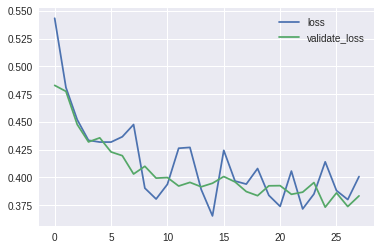

In [19]:
# plot some data
plt.plot(loss_history, label='loss')
plt.plot(dev_history, label='validate_loss')
plt.legend()

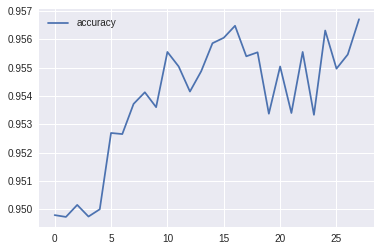

In [20]:
# accuracies
plt.plot(dev_acc_history, label='accuracy')
plt.legend()

##Submit the prediction


In [0]:
test_data = DATA_FILE.rsplit("/",1)[0] + '/test_txt' 




In [0]:
def predict_on_token_array(X): #index2token index2label
    X_enc = [token2index[x] for x in X]
    y_enc = model.predict(prepare_sequence(X_enc))
    return [index2label[y] for y in y_enc]

In [0]:
def predict_on_test_file(filename):
    ret = []
    with open(filename, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f.readlines():
            line_prediction = ' '.join(predict_on_token_array(line.split()))
            ret.append(line_prediction)
    return ret

In [0]:
import os
from tqdm import tqdm
ret= {}
print (tqdm(os.listdir(test_data)))
for fname in tqdm(os.listdir(test_data)):
  if fname.endswith('.txt'):
    ret[fname.replace('.txt', '')] = predict_on_test_file(test_data+'/'+fname)
    
  